# Tutorial 04: Implementing an analytical module for an X-ray component to allow gradient descent

### **What You Will Need**
- **Parameters**: $a, b, c, \dots$ to be estimated or optimized. 
- **An analtyical model**: $S(E; a, b, c, \dots)$ that defines the spectrum or energy response.  

### **What You Will Expect**
- How to build an **analtyical model**?
- Implementing the model using **PyTorch** for differentiability.
- A step-by-step guide to setting up and testing the interpolation module.

## A. Analytical Model of Filter
### A1. Background

In X-ray systems, filters are always used to protect the detector and enhance image quality by selectively absorbing low-energy X-rays that contribute to image noise without improving image contrast. According to Beer's law, the response of a single filter is

$$
f\left(E; m, \theta\right) = \mathrm{e}^{-\mu(E, m) \theta}
$$

where:

- $m$ denotes the filter material, which is a discrete parameter with only a limited set of choices. 
- $\mu(E, m)$ is the Linear Attenuation Coefficient (LAC) of material $m$ at energy $E$.
- $\theta$ denotes filter thickness, which is a continuous parameter within a continuous range.

### **A2. Step-by-Step Implementation**

To build an analytical model that supports **gradient descent**, we need two key functions:

1. **`__init__` (Initialize the Model)**  
   - Defines **materials** and **thickness** as model parameters.  
   - Assigns **separate memory for continuous parameters** corresponding to each discrete material selection.  
   - Enables **search over all material combinations**, allowing the model to explore different discrete parameter configurations.

2. **`forward` (Compute Filter Response)**  
   - Retrieves the current **material** and **thickness** for the filter. 
   - Calls `gen_fltr_res()` to compute the **X-ray attenuation response** using Beer's Law.  
   - Ensures the response is computed for a given set of **X-ray energies**.  

This setup enables **efficient spectral modeling and optimization** using PyTorch.


#### **Note 1: Material Class Overview**  

The `Material` class stores the **chemical formula** and **density** of a material, ensuring valid input types and allowing it to be used in X-ray modeling and optimization.

#### **Note 2: Get LAC value**
The `get_lin_att_c_vs_E` function calculates the linear attenuation coefficient (LAC) value with density, thickness, and energy vector.

#### **Note 3: `get_params()` Function Overview**  

The `get_params()` function, defined in `Base_Spec_Model`, retrieves the **estimated parameters** as a dictionary, applying **denormalization and clamping** to ensure they remain within valid bounds while maintaining gradient flow for optimization.

In [1]:
import numpy as np
import torch
from xcal.models import Base_Spec_Model
from xcal.defs import Material
from xcal.chem_consts._consts_from_table import get_lin_att_c_vs_E

# Implement the analytical model for filter.
def _obtain_attenuation(energies, formula, density, thickness, torch_mode=False):
    # thickness is mm
	mu = get_lin_att_c_vs_E(density, formula, energies)
	if torch_mode:
		mu = torch.tensor(mu)
		att = torch.exp(-mu * thickness)
	else:
		att = np.exp(-mu * thickness)
	return att

def gen_fltr_res(energies, fltr_mat:Material, fltr_th:float, torch_mode=True):

    return _obtain_attenuation(energies, fltr_mat.formula, fltr_mat.density, fltr_th, torch_mode)

# Gradient descent module.
class Filter(Base_Spec_Model):
    def __init__(self, materials, thickness):
        """
        A template filter model based on Beer's Law and NIST mass attenuation coefficients, including all necessary methods.

        Args:
            materials (list): A list of possible materials for the filter,
                where each material should be an instance containing formula and density.
            thickness (tuple or list): If a tuple, it should be (initial value, lower bound, upper bound) for the filter thickness.
                If a list, it should have the same length as the materials list, specifying thickness for each material.
                These values cannot be all None. It will not be optimized when lower == upper.
        """
        if isinstance(thickness, tuple):
            if all(t is None for t in thickness):
                raise ValueError("Thickness tuple cannot have all None values.")
            params_list = [{'material': mat, 'thickness': thickness} for mat in materials]
        elif isinstance(thickness, list):
            if len(thickness) != len(materials):
                raise ValueError("Length of thickness list must match length of materials list.")
            params_list = [{'material': mat, 'thickness': th} for mat, th in zip(materials, thickness)]
        else:
            raise TypeError("Thickness must be either a tuple or a list.")

        super().__init__(params_list)

    def forward(self, energies):
        """
        Takes X-ray energies and returns the filter response.

        Args:
            energies (torch.Tensor): A tensor containing the X-ray energies of a poly-energetic source in units of keV.

        Returns:
            torch.Tensor: The filter response as a function of input energies, selected material, and its thickness.
        """
		# Retrieves 
        mat = self.get_params()[f"{self.prefix}_material"]
        th = self.get_params()[f"{self.prefix}_thickness"]
        energies = torch.tensor(energies, dtype=torch.float32) if not isinstance(energies, torch.Tensor) else energies		
        return gen_fltr_res(energies, mat, th)


{'Filter_1_material': Material(formula='Al', density=2.702), 'Filter_1_thickness': tensor(2.5000, grad_fn=<ClampFunctionBackward>)}


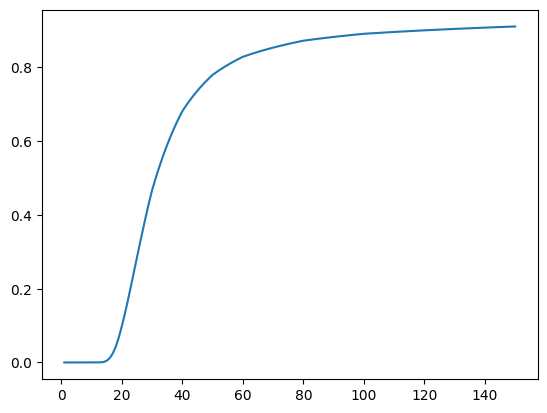

In [2]:
import matplotlib.pyplot as plt

th = 2.5 # target thickness in um

psb_fltr_mat = [Material(formula='Al', density=2.702), Material(formula='Cu', density=8.92)]
filter_1 = Filter(psb_fltr_mat, thickness=(th, 0, 10))

ee = np.linspace(1,150,150)
ff = filter_1(ee)
est_param = filter_1.get_params()
print(f'{est_param}')

plt.plot(ee, ff.data)